# Artificial Intelligence Homework 3
2017, Dec, 17

Use Hill Climbing(HC), Simulated Annealing(SA) and Genetic Algorithm(GA) to optimizing the following function.

$$f(x_1, x_2) = 21.5 + x_1 \, sin(4\pi x_1)+x_2 \, sin(20\pi x_2)$$

$$where\,-3.0 \le x_1 \le 12.1 \, and \, 4.1 \le x_2 \le 5.8$$

required precision is six places after the decimal points.

Reports must include:
- Result comparision for the above three optimization methods
- For GA, you need
    - the fitness curves (best and average of each generation and best-so-far)
    - the effects of population size, generation number, selection scheme, and genetic operator
    - a section of disscusion

## Genetic Algorithm
### Implement
- Using **[GAFT](https://github.com/PytLab/gaft)**, the Python Framwork for genetic algorithm computation.
- Discussion
    - Population Size
        - range from large to small
    - Generation Size
        - observe the plot
    - Selection Scheme
        - Proportionate Roulette Wheel Selection
        - Tournament Selection
        - Linear Ranking Selection
        - Exponential Ranking Selection
        - http://pytlab.org/2017/09/19/遗传算法中几种不同选择算子的比较/
    - Genetic Operator    

In [49]:
from gaft import GAEngine
from gaft.components import BinaryIndividual
from gaft.components import Population
from gaft.operators import *
from gaft.analysis.fitness_store import FitnessStore
from gaft.analysis.console_output import ConsoleOutput

import os
from math import sin, cos, pi, exp
import numpy as np

# Define Generation
generation = 70

# Define Population and the Constraints
population_size = 50
indv_template = BinaryIndividual(ranges = [(-3, 12.1), (4.1, 5.8)], eps = 0.001)
population = Population(indv_template = indv_template, size = population_size).init()

# Define Genetic Operators
## Selection : RouletteWheelSelection, TournamentSelection, LinearRankingSelection, ExpotentialRankingSelection
selection = RouletteWheelSelection()

## Crossover
### pc : probability of crossover(usually between 0.25 - 1.0)
### pe : gene exchange probability
crossover = UniformCrossover(pc=0.8, pe=0.5)

## Mutate
### pm : The probability of mutation (usually between 0.001 ~ 0.1)
### pbm : The probability of big mutation, usually more than 5 times bigger than pm
### alpha : intensive factor
mutation = FlipBitBigMutation(pm=0.1, pbm=0.55, alpha=0.6)

# Construct GA Engine
engine = GAEngine(population=population, 
                  selection=selection,
                  crossover=crossover, 
                  mutation=mutation,
                  analysis=[ConsoleOutput, FitnessStore])

# Define fitness function.
@engine.fitness_register
def fitness(indv):
    x1, x2 = indv.solution
    formula = 21.5 + x1*sin(4*pi*x1) + x2*sin(20*pi*x2)
    return formula

# Best Fitness values are export to best_fit.py
engine.run(ng = generation)

gaft.ConsoleOutput   INFO     Generation number: 70 Population number: 50
gaft.ConsoleOutput   INFO     Generation: 1, best fitness: 32.006, scaled fitness: 32.006
gaft.ConsoleOutput   INFO     Generation: 2, best fitness: 32.006, scaled fitness: 32.006
gaft.ConsoleOutput   INFO     Generation: 3, best fitness: 32.396, scaled fitness: 32.396
gaft.ConsoleOutput   INFO     Generation: 4, best fitness: 33.451, scaled fitness: 33.451
gaft.ConsoleOutput   INFO     Generation: 5, best fitness: 33.451, scaled fitness: 33.451
gaft.ConsoleOutput   INFO     Generation: 6, best fitness: 33.451, scaled fitness: 33.451
gaft.ConsoleOutput   INFO     Generation: 7, best fitness: 33.451, scaled fitness: 33.451
gaft.ConsoleOutput   INFO     Generation: 8, best fitness: 33.451, scaled fitness: 33.451
gaft.ConsoleOutput   INFO     Generation: 9, best fitness: 36.245, scaled fitness: 36.245
gaft.ConsoleOutput   INFO     Generation: 10, best fitness: 36.881, scaled fitness: 36.881
gaft.ConsoleOutput   INFO

### Evolution Curve

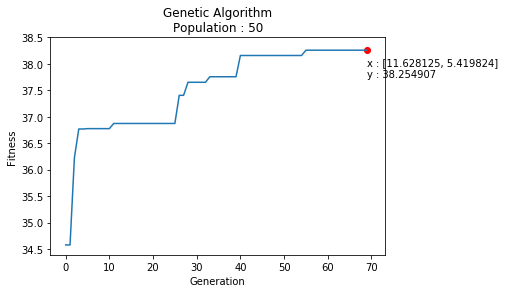

In [51]:
import matplotlib.pyplot as plt
from best_fit import best_fit

steps, variants, fits = list(zip(*best_fit))
best_step, best_v, best_f = steps[-1], variants[-1], fits[-1]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(steps, fits)
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness')

# Plot the Maximum
ax.scatter([best_step], [best_f], facecolor='r')
ax.annotate(s='x : [{:.6f}, {:.6f}]\ny : {:.6f}'.format(*best_v, best_f),
                                                     xy=(best_step, best_f),
                                                     xytext=(best_step, best_f-0.5))
plt.title("Genetic Algorithm\nPopulation : " + str(population_size))
plt.show()

### The Surface

In [52]:
import mpl_toolkits.mplot3d
from tqdm import tqdm

ctr = 0

for i, (x, y), z in tqdm(best_fit):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter([x], [y], [z], zorder=99, c='r', s=100)

    x, y = np.mgrid[-4:13:100j, 4:6:100j]
    z = 21.5+x*np.sin(4*np.pi*x) + y*np.sin(20*np.pi*y)
    ax.plot_surface(x, y, z, rstride=2, cstride=2, cmap=plt.cm.bone_r)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    if not os.path.exists('./surfaces'):
        os.mkdir('./surfaces')
    fig.savefig('./surfaces/{}.png'.format(i))
    ctr += 1
    plt.close(fig)

100%|██████████| 70/70 [00:34<00:00,  2.00it/s]


### Observe the Effect of Population

# Simulated Annealing

In [54]:
import random
import numpy as np
from math import sin, cos, pi, exp
import matplotlib.pyplot as plt

class OptimizeFunction:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.f = lambda x, y: 21.5 + x*sin(4*pi*x) + y*sin(20*pi*y)

    # Constraints
    def calculate(self):
        x, y = {random.uniform(-3,  12.1), random.uniform(4.1, 5.8)}
        result = {"x" : x, "y" : y, "result" : self.f(x, y)}
        return result
    
class Probability:
    def calculate(self, current_result, next_result, Temp):
        delta = next_result - current_result
        if(delta >= 0) :
            return 1
        else:
            return np.exp(delta / Temp)

In [57]:
class SimulateAnnealing:
    def __init__(self, Temp, min_Temp, cooling_rate, length, Function, Probability):
        self.Temp = Temp
        self.min_Temp = min_Temp
        self.cooling_rate = cooling_rate
        self.length = length
        self.Function = Function
        self.Probability = Probability
        
    def getSolution(self):
        iteration = []
        Temp = self.Temp
        min_Temp = self.min_Temp
        cooling_rate = self.cooling_rate
        length = self.length

        current_result = best_so_far = self.Function.calculate()
        best_so_far["Temp"] = Temp
        iteration.append(current_result["result"])

        while Temp > min_Temp:
            i = 0
            while i <= length:
                next_result = self.Function.calculate()
                iteration.append(next_result["result"])

                # Update the result
                if(next_result["result"] > current_result["result"]):
                    best_so_far = next_result
                    best_so_far["Temp"] = Temp
                    #print("Best_so_far", best_so_far, "Temp", Temp)


                # Calculate the probabiltity of accept next state
                prob = self.Probability.calculate(current_result["result"], next_result["result"], Temp)
                if prob > random.random():
                    current_result = next_result
                i += 1

            Temp = Temp * cooling_rate
        return best_so_far, iteration

In [62]:
initial_x, initial_y = {random.uniform(-3,  12.1), random.uniform(4.1, 5.8)}
Temp = 100
Min_Temp = 1
Length = 100
Cooling_Rate = 0.99

optimizeFunction = OptimizeFunction(initial_x, initial_y)
sa = SimulateAnnealing(Temp, Min_Temp, Cooling_Rate, Length, optimizeFunction, Probability())
solution, result = sa.getSolution()
print("Best Solution")
print(solution)
print("length of iteration",len(result))

Best Solution
{'x': 11.156041497488465, 'y': 4.628230024793558, 'result': 36.35123170550179, 'Temp': 1.0021186061657157}
length of iteration 46360


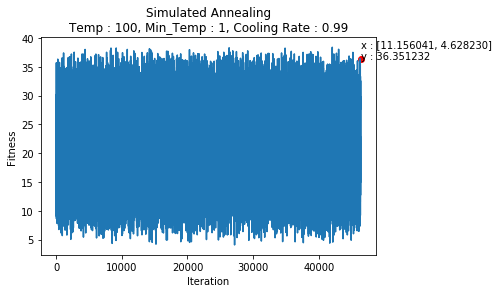

In [63]:
# Plot the iteration
plt.scatter(len(result), solution["result"], facecolor='r')
plt.annotate(s = 'x : [{:.6f}, {:.6f}]\ny : {:.6f}'.format(solution["x"], solution["y"], solution["result"]), xy = (len(result), solution["result"]))
plt.plot(range(len(result)),result)
plt.title("Simulated Annealing\n" + "Temp : " + str(Temp) + ", Min_Temp : " + str(Min_Temp) + ", Cooling Rate : " + str(Cooling_Rate))
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.show()